# **Analysis of Big data**


# Setting up PySpark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [4]:
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"


In [5]:
import findspark
findspark.init()


In [6]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Import Packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import isnull, when, count, isnan, col, lit, udf, dayofweek, date_format, month, countDistinct
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest, Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, UnivariateFeatureSelector
from pyspark.sql.functions import col, when
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Loading the Data

We are analyzing the USA Airline and Cancellation dataset from Kaggle (https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018/code?resource=download&select=2018.csv). The dataset includes information (28 columns; both categorical and numerical) on 7.2 million flights taken across the United States during the year 2018.

In [8]:
# Install required package to read Excel
!pip install -q openpyxl

# Step 1: Convert Excel to CSV using pandas
import pandas as pd

excel_df = pd.read_excel('Online Retail.xlsx')  # or whatever the filename is after upload
excel_df.to_csv('online_retail.csv', index=False)

# Step 2: Load the CSV into Spark
df = spark.read.csv('online_retail.csv', header=True, inferSchema=True)

# Step 3: Check data
df.printSchema()
df.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365| 

In [9]:
display(df)

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

In [10]:
display(df.describe().toPandas())

,summary,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,count,541909,541909,540455,541909,541909,406829,541909
1,mean,559965.752026781,27623.240210938104,20713.0,9.55224954743324,4.61111362608298,15287.690570239585,None
2,stddev,13428.417280803813,16799.737628427752,None,218.08115785023477,96.75985306117967,1713.6003033215982,None
3,min,536365,10002,4 PURPLE FLOCK DINNER CANDLES,-80995,-11062.06,12346.0,Australia
4,max,C581569,m,wrongly sold sets,80995,38970.0,18287.0,Unspecified


In [11]:
from pyspark.sql.functions import col

# 1. Drop rows where CustomerID or Description is null
df = df.dropna(subset=["CustomerID", "Description"])

# 2. Remove cancelled transactions (InvoiceNo starts with 'C')
df = df.filter(~col("InvoiceNo").startswith("C"))

# 3. Remove rows with negative Quantity or UnitPrice
df = df.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# 4. Create TotalPrice column
df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))


In [12]:
display(df.describe().toPandas())

,summary,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice
0,count,397884,397884,397884,397884,397884,397884,397884,397884
1,mean,560616.9344507444,27420.411850034085,None,12.988237777844798,3.1164877552256525,15294.423452564064,None,22.396999889417703
2,stddev,13106.117772962025,16391.025997723667,None,179.33177496319982,22.09787663086808,1713.1415604398514,None,309.0710414140181
3,min,536365,10002,4 PURPLE FLOCK DINNER CANDLES,1,0.001,12346.0,Australia,0.001
4,max,581587,POST,ZINC WIRE SWEETHEART LETTER TRAY,80995,8142.75,18287.0,Unspecified,168469.6


In [13]:
# Top 10 countries by total revenue
df.groupBy("Country").sum("TotalPrice").orderBy("sum(TotalPrice)", ascending=False).show(10)

# Most sold items
df.groupBy("Description").sum("Quantity").orderBy("sum(Quantity)", ascending=False).show(10)

# Monthly revenue trends
from pyspark.sql.functions import month, year

df = df.withColumn("InvoiceMonth", month("InvoiceDate")).withColumn("InvoiceYear", year("InvoiceDate"))
df.groupBy("InvoiceYear", "InvoiceMonth").sum("TotalPrice").orderBy("InvoiceYear", "InvoiceMonth").show()


+--------------+------------------+
|       Country|   sum(TotalPrice)|
+--------------+------------------+
|United Kingdom| 7308391.554000224|
|   Netherlands| 285446.3399999992|
|          EIRE|265545.89999999915|
|       Germany|228867.14000000025|
|        France|209024.05000000025|
|     Australia|138521.30999999976|
|         Spain| 61577.11000000017|
|   Switzerland| 56443.95000000007|
|       Belgium| 41196.34000000001|
|        Sweden| 38378.32999999999|
+--------------+------------------+
only showing top 10 rows

+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|PAPER CRAFT , LIT...|        80995|
|MEDIUM CERAMIC TO...|        77916|
|WORLD WAR 2 GLIDE...|        54415|
|JUMBO BAG RED RET...|        46181|
|WHITE HANGING HEA...|        36725|
|ASSORTED COLOUR B...|        35362|
|PACK OF 72 RETROS...|        33693|
|      POPCORN HOLDER|        30931|
|  RABBIT NIGHT LIGHT|        27202|
|MINI PAINT SET VI...|    

In [14]:
# Example: customer-level aggregation
customer_df = df.groupBy("CustomerID").agg(
    {"TotalPrice": "sum", "InvoiceNo": "count"}
).withColumnRenamed("sum(TotalPrice)", "TotalSpend").withColumnRenamed("count(InvoiceNo)", "NumPurchases")

customer_df.show(5)


+----------+------------------+------------+
|CustomerID|        TotalSpend|NumPurchases|
+----------+------------------+------------+
|   16916.0| 576.2599999999999|         143|
|   17884.0| 717.4499999999998|         117|
|   13094.0|1927.3200000000002|          24|
|   16596.0|            250.15|          12|
|   18114.0|             220.1|          28|
+----------+------------------+------------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import col, max, datediff

# Get the latest date in the dataset
max_date = df.select(max("InvoiceDate")).first()[0]

# Compute recency for each customer
recency_df = df.groupBy("CustomerID").agg(
    max("InvoiceDate").alias("LastPurchaseDate")
).withColumn(
    "Recency", datediff(lit(max_date), col("LastPurchaseDate"))
)

# Merge with total spend & purchases
rfm_df = customer_df.join(recency_df, on="CustomerID")


In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["TotalSpend", "NumPurchases", "Recency"],
    outputCol="features"
)

rfm_vector = assembler.transform(rfm_df)


In [18]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(rfm_vector)
clusters = model.transform(rfm_vector)


In [19]:
clusters.groupBy("cluster").agg(
    {"TotalSpend": "avg", "NumPurchases": "avg", "Recency": "avg", "*": "count"}
).show()


+-------+------------------+------------------+-----------------+--------+
|cluster|   avg(TotalSpend)|      avg(Recency)|avg(NumPurchases)|count(1)|
+-------+------------------+------------------+-----------------+--------+
|      1| 269931.6599999997|               0.5|           1253.5|       2|
|      3| 46393.01387096775|30.032258064516128|993.1612903225806|      31|
|      2|149828.50199999992|               8.4|           1625.8|       5|
|      0|1438.1903823255827| 92.64651162790697|82.89767441860465|    4300|
+-------+------------------+------------------+-----------------+--------+



 High-value & active — Only 2 customers, but they spend huge amounts and buy very frequently. Super loyal.

 Big spenders — A bit less recent than Cluster 1, but still very active and profitable. Great targets for loyalty rewards.

 Mid-tier regulars — Moderate spenders and fairly recent. They form a good base for upselling/cross-selling.

 Low-value or inactive — Large chunk (4300 customers), but low spending, low frequency, and high recency (i.e., haven't shopped in a while). Might be churned or casual shoppers.

**EDA**

In [22]:
from pyspark.sql.functions import datediff, max as spark_max

# 1. Get latest invoice date
latest_date = df.select(spark_max("InvoiceDate")).collect()[0][0]

# 2. Calculate Recency for each customer
from pyspark.sql.functions import col
recency_df = df.groupBy("CustomerID").agg(spark_max("InvoiceDate").alias("LastPurchaseDate"))
recency_df = recency_df.withColumn("Recency", datediff(lit(latest_date), col("LastPurchaseDate")))

# 3. Merge with customer_df
customer_df = customer_df.join(recency_df.select("CustomerID", "Recency"), on="CustomerID", how="inner")


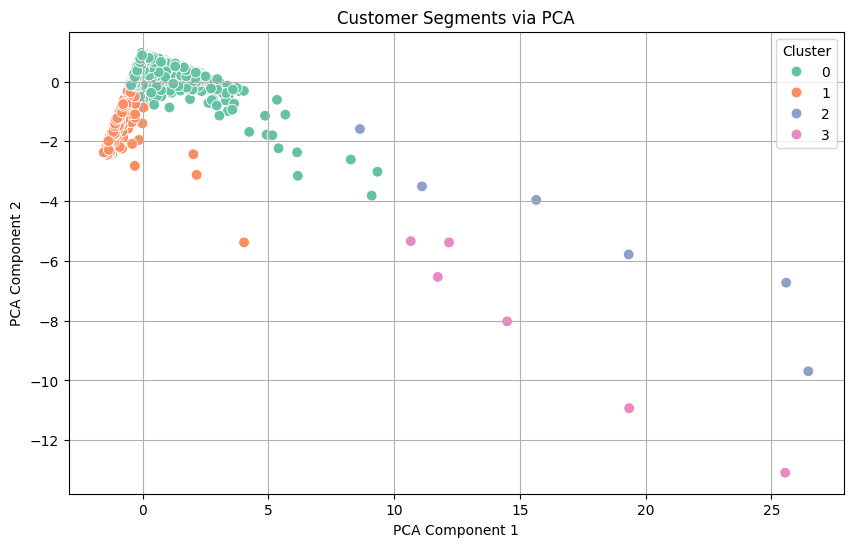

In [25]:
from pyspark.sql.functions import col, max as spark_max, count, sum as spark_sum, lit as spark_lit, datediff
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure TotalPrice column exists
df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# Step 1: Calculate RFM features
max_date = df.select(spark_max("InvoiceDate")).collect()[0][0]

rfm_df = df.groupBy("CustomerID").agg(
    spark_sum("TotalPrice").alias("TotalSpend"),
    count("InvoiceNo").alias("NumPurchases"),
    spark_max("InvoiceDate").alias("LastPurchaseDate")
).withColumn(
    "Recency", datediff(spark_lit(max_date), col("LastPurchaseDate"))
).select("CustomerID", "TotalSpend", "NumPurchases", "Recency")

# Step 2: VectorAssembler
assembler = VectorAssembler(inputCols=["Recency", "NumPurchases", "TotalSpend"], outputCol="features")
rfm_features = assembler.transform(rfm_df)

# Step 3: Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaled_data = scaler.fit(rfm_features).transform(rfm_features)

# Step 4: KMeans Clustering
kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=42)
model = kmeans.fit(scaled_data)
clustered = model.transform(scaled_data)

# Step 5: PCA for dimensionality reduction
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(clustered)
pca_result = pca_model.transform(clustered)

# Step 6: Join with cluster info
customer_clusters = clustered.select("CustomerID", "prediction").withColumnRenamed("prediction", "cluster")
final_df = pca_result.join(customer_clusters, on="CustomerID", how="inner")

# Step 7: Convert to Pandas and prepare for visualization
pandas_df = final_df.select("pcaFeatures", "cluster").toPandas()
pandas_df[['pca1', 'pca2']] = pandas_df['pcaFeatures'].apply(lambda x: pd.Series(x.toArray()))

# Step 8: Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=60)
plt.title('Customer Segments via PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [27]:
# Rejoin the cluster predictions with the original RFM features
clustered_df = customer_df.join(customer_clusters, on="CustomerID", how="inner")

# Now perform cluster profiling
from pyspark.sql import functions as F

clustered_df.groupBy("cluster").agg(
    F.avg("TotalSpend").alias("AvgSpend"),
    F.avg("NumPurchases").alias("AvgPurchases"),
    F.avg("Recency").alias("AvgRecency"),
    F.count("*").alias("NumCustomers")
).orderBy("cluster").show()


+-------+------------------+------------------+------------------+------------+
|cluster|          AvgSpend|      AvgPurchases|        AvgRecency|NumCustomers|
+-------+------------------+------------------+------------------+------------+
|      0| 2070.911963339495|103.09519408502773| 40.89525569932224|        3246|
|      1| 636.5011120370376|27.749074074074073| 246.8138888888889|        1080|
|      2|59437.616666666676| 4717.833333333333|1.1666666666666667|           6|
|      3|190863.46166666652| 826.8333333333334|               7.0|           6|
+-------+------------------+------------------+------------------+------------+



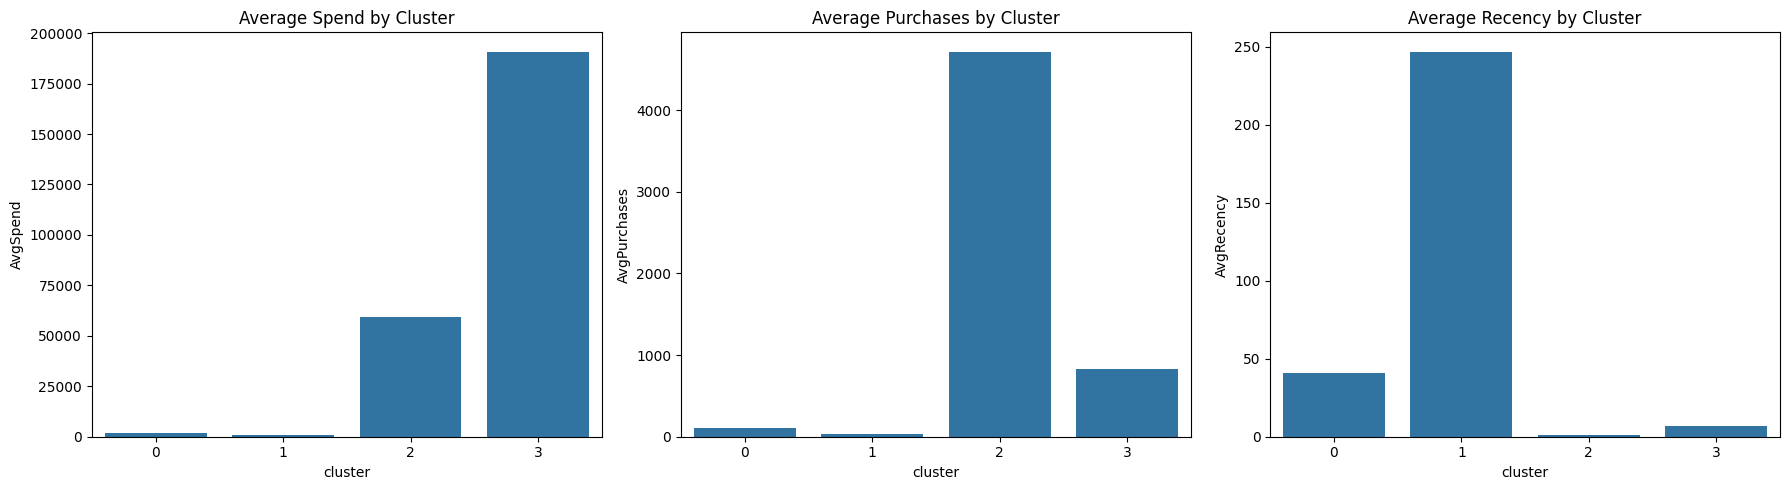

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
cluster_summary = clustered_df.groupBy("cluster").agg(
    F.avg("TotalSpend").alias("AvgSpend"),
    F.avg("NumPurchases").alias("AvgPurchases"),
    F.avg("Recency").alias("AvgRecency"),
    F.count("*").alias("NumCustomers")
).orderBy("cluster").toPandas()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='cluster', y='AvgSpend', data=cluster_summary, ax=axs[0])
axs[0].set_title('Average Spend by Cluster')

sns.barplot(x='cluster', y='AvgPurchases', data=cluster_summary, ax=axs[1])
axs[1].set_title('Average Purchases by Cluster')

sns.barplot(x='cluster', y='AvgRecency', data=cluster_summary, ax=axs[2])
axs[2].set_title('Average Recency by Cluster')

plt.tight_layout()
plt.show()


1. Cluster 0 (Low Spend, Moderate Recency & Frequency)
Spend: Very low

Purchases: Low-moderate

Recency: Moderate (~40 days)

Insight: These are regular but low-value customers. Possibly budget-conscious or casual buyers.

2. Cluster 1 (Low-Value Dormant Customers)
Spend: Very low

Purchases: Lowest

Recency: Extremely high (~250)

Insight: Cold/inactive users. Haven’t interacted recently, may need reactivation campaigns.

3. Cluster 2 (High-Volume Power Buyers)
Spend: High

Purchases: Extremely high (~4700)

Recency: Extremely low

Insight: Super loyal and highly engaged customers — your gold tier. Retention here is key.

4. Cluster 3 (High-Spenders, Fewer Transactions)
Spend: Highest

Purchases: Moderate

Recency: Low (~7)

Insight: Likely bulk buyers or premium shoppers. They buy infrequently, but when they do, it’s huge.



In [29]:
from pyspark.sql.functions import when

clustered_df = clustered_df.withColumn("Segment", when(F.col("cluster") == 0, "Regular Low-Spend") \
                                                  .when(F.col("cluster") == 1, "Dormant") \
                                                  .when(F.col("cluster") == 2, "Power Users") \
                                                  .when(F.col("cluster") == 3, "High Spenders"))


**ML**

Type: Multiclass Classification

Goal: Predict customer segments (cluster) based on behavioral features: TotalSpend, NumPurchases, and Recency.

In [30]:
from pyspark.ml.feature import StringIndexer

# Make sure label column is indexed properly
indexer = StringIndexer(inputCol="cluster", outputCol="label")
labeled_data = indexer.fit(customer_clusters).transform(customer_clusters)


In [32]:
# Join clustered labels with the original RFM data
labeled_data = customer_df.join(clustered_df.select("CustomerID", "cluster", "Segment"), on="CustomerID", how="inner")


 Spark ML **Pipeline**

In [33]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["TotalSpend", "NumPurchases", "Recency"],
    outputCol="features"
)

assembled_data = assembler.transform(labeled_data)
assembled_data.select("features", "cluster", "Segment").show(5, truncate=False)


+------------------------------+-------+-----------------+
|features                      |cluster|Segment          |
+------------------------------+-------+-----------------+
|[576.2599999999999,143.0,23.0]|0      |Regular Low-Spend|
|[717.4499999999998,117.0,3.0] |0      |Regular Low-Spend|
|[1927.3200000000002,24.0,21.0]|0      |Regular Low-Spend|
|[250.15,12.0,15.0]            |0      |Regular Low-Spend|
|[220.1,28.0,290.0]            |1      |Dormant          |
+------------------------------+-------+-----------------+
only showing top 5 rows



In [34]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Segment", outputCol="label")
labeled_data = indexer.fit(assembled_data).transform(assembled_data)


In [35]:
final_data = assembled_data.withColumnRenamed("cluster", "label")


In [36]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train_data)


In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9951


In [39]:
predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    2|
|    0|       0.0|  621|
|    1|       1.0|  196|
|    3|       0.0|    1|
|    0|       1.0|    1|
+-----+----------+-----+



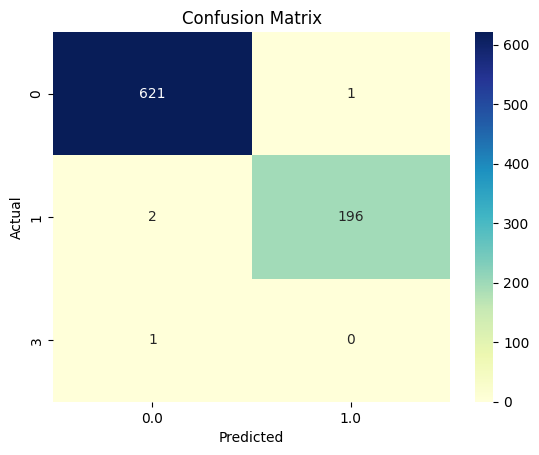

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas
pdf = predictions.select("label", "prediction").toPandas()

# Confusion matrix heatmap
conf_matrix = pd.crosstab(pdf['label'], pdf['prediction'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.show()


Cluster 0 and 1 are extremely well classified.

Only one sample from cluster 3 is present, and it was misclassified — probably due to class imbalance (cluster 3 might be underrepresented).

No instances of cluster 2 appeared in your test set or confusion matrix — likely because it's very rare (as we saw in EDA: only 6 users in that cluster).


In [43]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Step 1: Define your model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Step 2: Build your ML Pipeline (if you have additional stages, add them here)
pipeline = Pipeline(stages=[lr])

# Step 3: Define evaluator (we'll use accuracy here)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Step 4: Define hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Step 5: Define cross-validator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5,  # 5-fold cross-validation
                    parallelism=2)  # Adjust based on available cores

# Step 6: Train using cross-validation
cv_model = cv.fit(train_data)

# Step 7: Evaluate on test data
predictions = cv_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

print(f"Best Model Accuracy on Test Data: {accuracy:.4f}")
best_model = cv_model.bestModel.stages[0]
print(f"Best RegParam: {best_model._java_obj.getRegParam()}")
print(f"Best ElasticNetParam: {best_model._java_obj.getElasticNetParam()}")


Best Model Accuracy on Test Data: 0.9951
Best RegParam: 0.01
Best ElasticNetParam: 1.0
